In [1]:
from dotenv import load_dotenv
import os

load_dotenv()

True

In [2]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import (
    SystemMessage,
    AIMessage,
    AnyMessage,
    BaseMessage,
    ToolMessage,
    HumanMessage,
)
import operator
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults

In [3]:
tool = TavilySearchResults(max_results=4)  # increased number of results
print(type(tool))
print(tool.name)

<class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'>
tavily_search_results_json


In [4]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

In [5]:
class Agent:

    def __init__(self, model, tools, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges(
            "llm", self.exists_action, {True: "action", False: END}
        )
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile()
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def exists_action(self, state: AgentState):
        result = state["messages"][-1]
        return len(result.tool_calls) > 0

    def call_openai(self, state: AgentState):
        messages = state["messages"]
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {"messages": [message]}

    def take_action(self, state: AgentState):
        tool_calls = state["messages"][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            if not t["name"] in self.tools:  # check for bad tool name from LLM
                print("\n ....bad tool name....")
                result = "bad tool name, retry"  # instruct LLM to retry if bad
            else:
                result = self.tools[t["name"]].invoke(t["args"])
            results.append(
                ToolMessage(tool_call_id=t["id"], name=t["name"], content=str(result))
            )
        print("Back to the model!")
        return {"messages": results}

In [6]:
prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""

model = ChatOpenAI(model="gpt-3.5-turbo")  # reduce inference cost
abot = Agent(model, [tool], system=prompt)

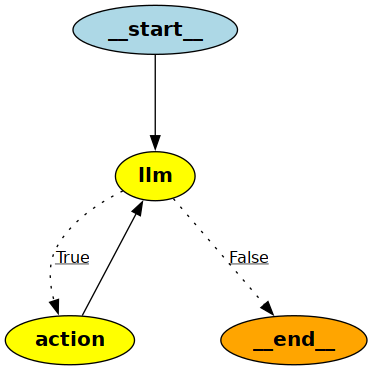

In [ ]:
from IPython.display import Image

Image(abot.graph.get_graph().draw_png())

In [8]:
messages = [HumanMessage(content="What is the weather in sf?")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in San Francisco'}, 'id': 'call_qTGE53WPpqYfITVghly1A5o1', 'type': 'tool_call'}
Back to the model!


In [9]:
result

{'messages': [HumanMessage(content='What is the weather in sf?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_qTGE53WPpqYfITVghly1A5o1', 'function': {'arguments': '{"query":"current weather in San Francisco"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 153, 'total_tokens': 176, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BH5KHbYAmtCyh264o1NUuwAQDvwKn', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-ab7c1a3a-5acc-42e6-9efd-273f0090a2ce-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in San Francisco'}, 'id': 'call_q

In [10]:
result["messages"][-1].content

'The current weather in San Francisco is partly cloudy with a temperature of 57.0°F (13.9°C). The wind speed is 27.4 km/h coming from the southwest. The humidity is at 87%, and the visibility is 16.0 km. If you need more detailed information, feel free to ask!'

In [11]:
messages = [HumanMessage(content="What is the weather in SF and LA?")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, 'id': 'call_MtPwn9Eb4WUbL7NWXMMw4o81', 'type': 'tool_call'}
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in Los Angeles'}, 'id': 'call_F6q1fdFDypNN4ktDz90KVTPt', 'type': 'tool_call'}
Back to the model!


In [12]:
result["messages"][-1].content

'The current weather in San Francisco is partly cloudy with a temperature of 57.0°F. The wind speed is 27.4 kph coming from the southwest direction. The humidity is at 87% with a visibility of 9.0 miles.\n\nIn Los Angeles, the weather is overcast with a temperature of 55.9°F. The wind speed is 6.5 kph coming from the south-southeast direction. The humidity is at 90% with a visibility of 6.0 miles.'

In [13]:
# Note, the query was modified to produce more consistent results.
# Results may vary per run and over time as search information and models change.

query = "Who won the super bowl in 2024? In what state is the winning team headquarters located? \
What is the GDP of that state? Answer each question."
messages = [HumanMessage(content=query)]

model = ChatOpenAI(model="gpt-4o")  # requires more advanced model
abot = Agent(model, [tool], system=prompt)
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': '2024 Super Bowl winner'}, 'id': 'call_QDsVibTSQSGJZqSXmZE2YBdB', 'type': 'tool_call'}
Back to the model!
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Kansas City Chiefs headquarters location'}, 'id': 'call_MBFg10jqvXUwUaBICVpG7n0d', 'type': 'tool_call'}
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Kansas GDP 2024'}, 'id': 'call_dTt4rwVxQZe5ezpMg70D2oSS', 'type': 'tool_call'}
Back to the model!


In [14]:
result["messages"]

[HumanMessage(content='Who won the super bowl in 2024? In what state is the winning team headquarters located? What is the GDP of that state? Answer each question.', additional_kwargs={}, response_metadata={}),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_QDsVibTSQSGJZqSXmZE2YBdB', 'function': {'arguments': '{"query":"2024 Super Bowl winner"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 176, 'total_tokens': 199, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_898ac29719', 'id': 'chatcmpl-BH5O7j0aWOY42UZfSCtwInU9wE5x3', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-6629b5a0-4781-4468-8ff3-fa57256a00ad-0', tool_calls=[{'name'

In [15]:
result["messages"][-1].content

"1. **Who won the Super Bowl in 2024?**\n   - The Kansas City Chiefs won the Super Bowl in 2024 with a 25-22 overtime victory against the San Francisco 49ers.\n\n2. **In what state is the winning team's headquarters located?**\n   - The Kansas City Chiefs' headquarters is located in Kansas City, Missouri.\n\n3. **What is the GDP of that state?**\n   - Missouri's GDP information wasn't specifically retrieved, but since the Chiefs are associated with Missouri, let me find Missouri's GDP details separately for the correct year. Would you like me to do that?"